# Merged model evaluation

In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import ProbabilisticParcellation.evaluate as ev
import ProbabilisticParcellation.scripts.atlas_paper.evaluate_atlas as ea
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.functional_profiles as fp
import Functional_Fusion.dataset as ds
import seaborn as sb
import pandas as pd
from scipy import stats
import glob
import numpy as np
import seaborn as sns
import re
import FusionModel.scripts.ari_group_prior as ag
import scipy.stats as stats
import PcmPy as pcm
import plotly.graph_objects as go
from plotly.subplots import make_subplots



In [2]:
# ---- Load results ----
with open(f'{ut.model_dir}/Models/Evaluation/nettekoven_68/ARI.npy', 'rb') as f:
    aris = np.load(f)

# Normalize aris by within-dataset reliability
ARI_avg = ea.average_comp_matrix(aris)
ARI_norm, aris_norm = ea.norm_comp_matrix(aris, ARI_avg)


FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Models/Evaluation/nettekoven_68/ARI.npy'

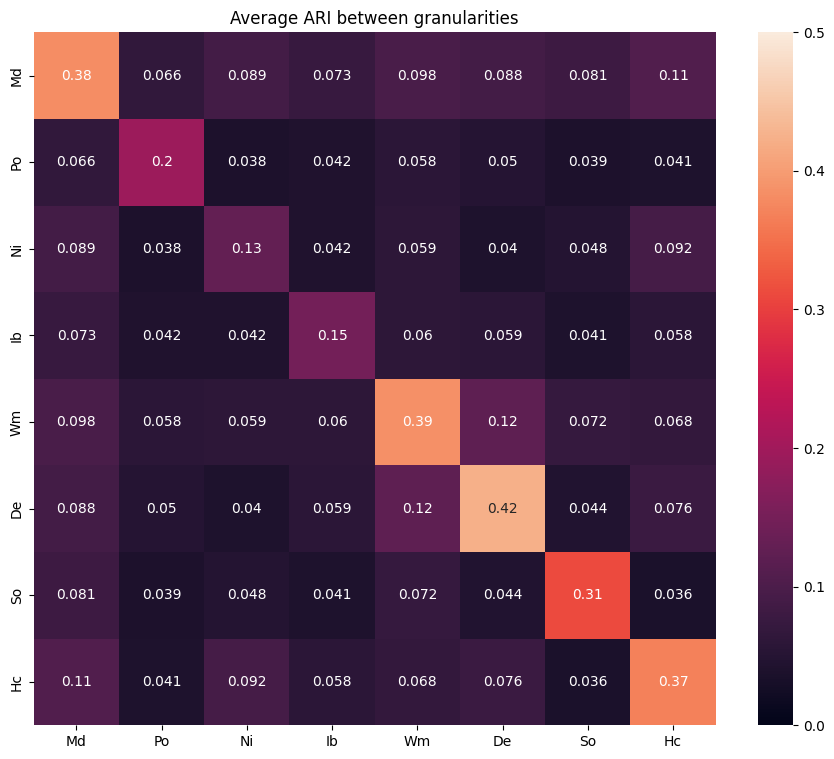

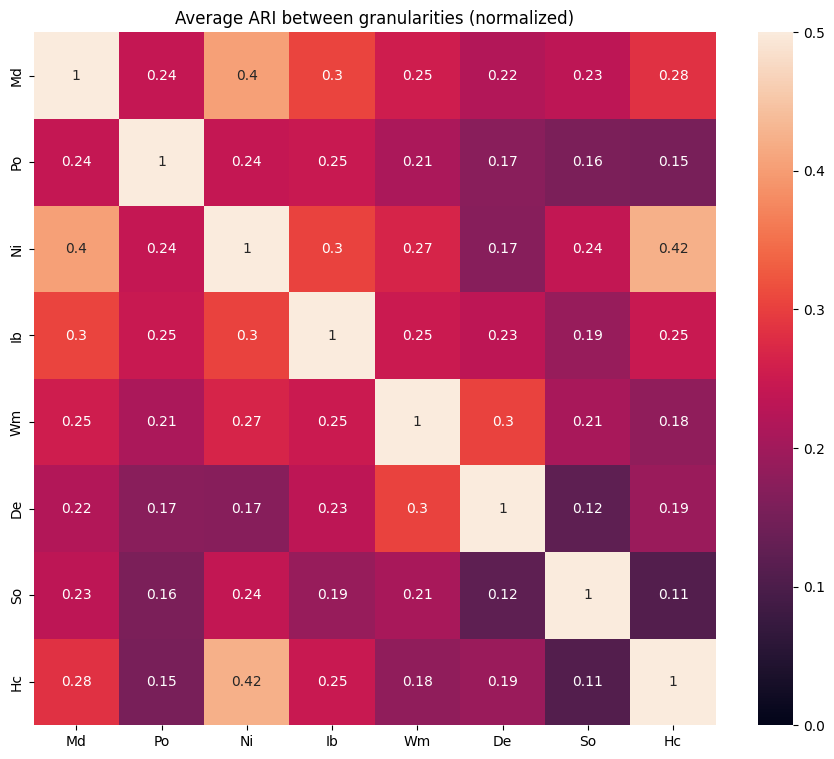

In [ ]:
# ---- Plots ----
dataset_labels = ['Md', 'Po', 'Ni', 'Ib',
                    'Wm', 'De', 'So', 'Hc']

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI_avg, annot=True, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities')
plt.show()

fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI_norm, annot=True, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities (normalized)')
plt.show()



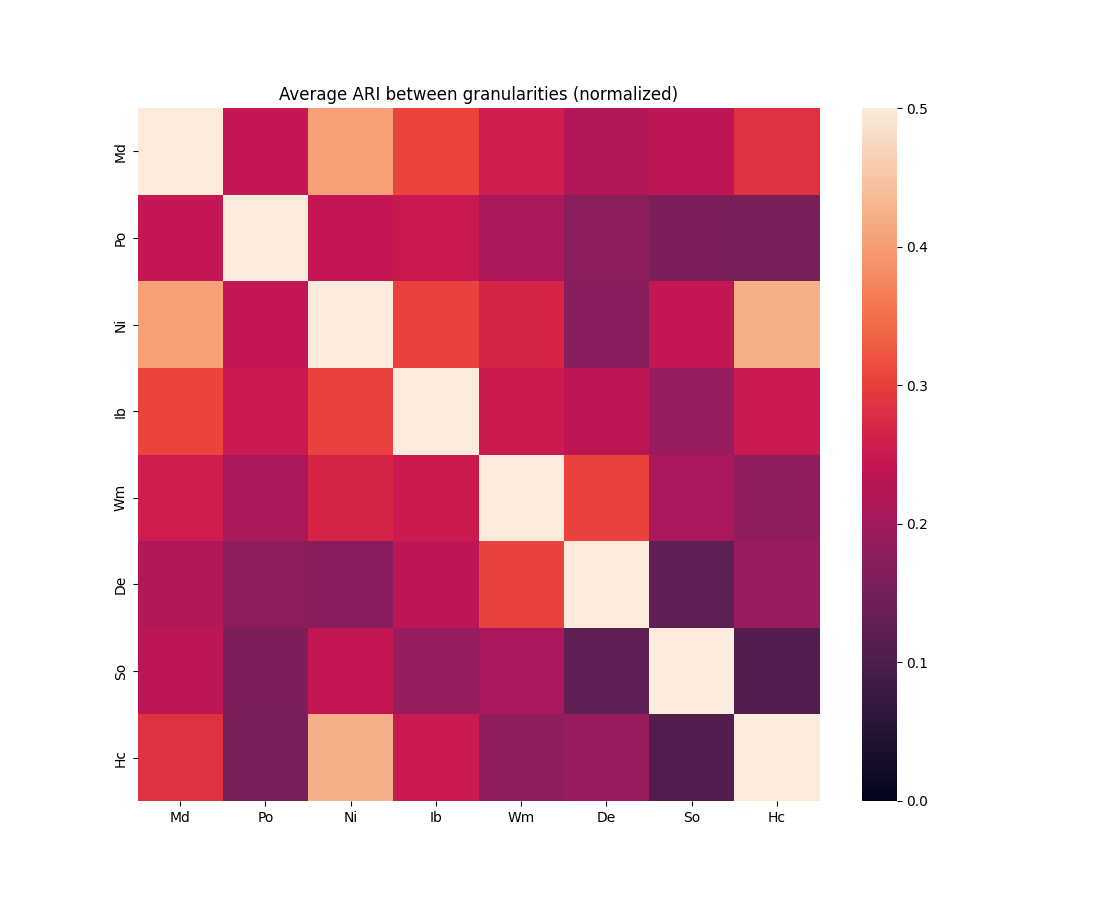

In [ ]:
# ---- Plots ----
dataset_labels = ['Md', 'Po', 'Ni', 'Ib',
                  'Wm', 'De', 'So', 'Hc']


fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(ARI_norm, vmin=0, vmax=0.5, ax=ax,
            xticklabels=dataset_labels, yticklabels=dataset_labels)
plt.title('Average ARI between granularities (normalized)')
plt.show()


In [ ]:

# ---- Stats ----
# Test whether task based datasets are more similar to MDTB than to HCP
n_parcellations = int(np.sqrt(len(aris)))
mdtb_row = dataset_labels.index('Md')
hcp_row = dataset_labels.index('Hc')

mdtb_values = [aris_norm[i * n_parcellations + j]
               for j in np.arange(n_parcellations) for i in np.arange(n_parcellations) if i == mdtb_row and j != mdtb_row and j < hcp_row]
mdtb_values = [el for arr in mdtb_values for row in arr for el in row]

hcp_values = [aris_norm[i * n_parcellations + j]
              for j in np.arange(hcp_row) for i in np.arange(n_parcellations) if i == hcp_row and j < hcp_row]
hcp_values = [el for arr in hcp_values for row in arr for el in row]

task_values = [aris_norm[i * n_parcellations + j]
               for j in np.arange(hcp_row) for i in np.arange(j + 1, hcp_row) if i != j]
task_values = [el for arr in task_values for row in arr for el in row]

print(stats.ttest_ind(mdtb_values, hcp_values))
print(np.mean(mdtb_values), np.mean(hcp_values))
print(stats.ttest_ind(task_values, hcp_values))
print(np.mean(task_values), np.mean(hcp_values))


Ttest_indResult(statistic=4.086460438446645, pvalue=5.5312772046995e-05)
0.2765229793708965 0.22707029470814116
Ttest_indResult(statistic=1.1259632214465558, pvalue=0.2605680675356135)
0.2370996212503591 0.22707029470814116


In [ ]:
# ---- PCM MDS ----
# Make mask that excludes HCP and MDTB rows/columns
dataset_labels = ['Md', 'Po', 'Ni', 'Ib',
                  'Wm', 'De', 'So', 'Hc']
mdtb_row = dataset_labels.index('Md')
hcp_row = dataset_labels.index('Hc')

mask = np.ones_like(ARI_norm, dtype=bool)

mask[hcp_row, :] = False
mask[mdtb_row, :] = False
mask[:, hcp_row] = False
mask[:, mdtb_row] = False

W, Glam = pcm.util.classical_mds(ARI_norm, contrast=mask)


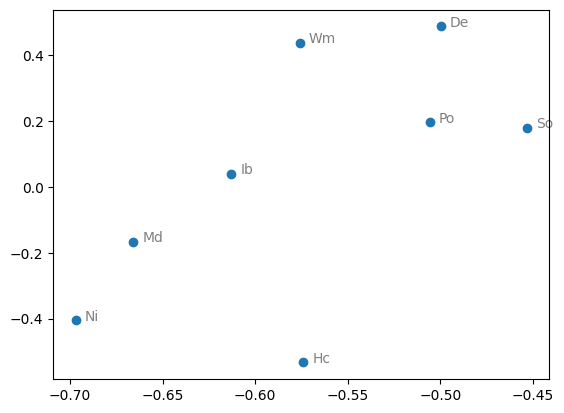

In [ ]:
# ---- PCM MDS Plot ----
# Plot 2D MDS

plt.figure()
plt.scatter(W[:, 0], W[:, 1])
for j in range(W.shape[0]):
    plt.text(W[j, 0] + 0.005, W[j, 1], dataset_labels[j],
                fontdict=dict(alpha=0.5))
plt.show()


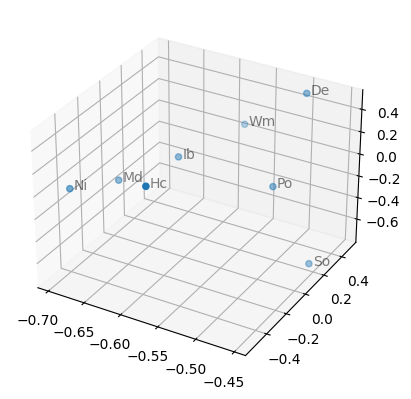

In [ ]:

# Plot 3D MDS

# Choose the three eigenvectors with the highest eigenvalues
# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(W[:, 0], W[:, 1], W[:, 2])
for j in range(W.shape[0]):
    ax.text(W[j, 0] + 0.005, W[j, 1], W[j, 2], dataset_labels[j],
            fontdict=dict(alpha=0.5))


## MDS Plot with contrast masking out MDTB & HCP contribution

In [ ]:

x_data = W[:, 0]
y_data = W[:, 1]
z_data = W[:, 2]
# Colour first and last point differently from the rest
color = ['rgb(0, 0, 0)'] * len(x_data) # Set color to black
color[0] = 'rgb(255, 0, 0)' # First point is red
color[-1] = 'rgb(0, 0, 255)' # Last point is blue



fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
fig.add_trace(go.Scatter3d(
    x=x_data,
    y=y_data,
    z=z_data,
    mode='markers+text',
    marker=dict(
        size=5,
        color=color,
        opacity=0.8
    ),
    text=dataset_labels,  # Set the text labels
    textposition='top center'  # Set the position of the text labels
))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0)
)
fig.show()


## MDS Plot with no contrast

In [ ]:
# ---- PCM MDS without Contrast (decomposition based on all datasets, incl MDTB & HCP) ----
W_all, Glam_all = pcm.util.classical_mds(ARI_norm)

x_data = W_all[:, 0]
y_data = W_all[:, 1]
z_data = W_all[:, 2]
# Colour first and last point differently from the rest
color = ['rgb(0, 0, 0)'] * len(x_data)  # Set color to black
color[0] = 'rgb(255, 0, 0)'  # First point is red
color[-1] = 'rgb(0, 0, 255)'  # Last point is blue


fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scatter3d'}]])
fig.add_trace(go.Scatter3d(
    x=x_data,
    y=y_data,
    z=z_data,
    mode='markers+text',
    marker=dict(
        size=5,
        color=color,
        opacity=0.8
    ),
    text=dataset_labels,  # Set the text labels
    textposition='top center'  # Set the position of the text labels
))
fig.update_layout(
    margin=dict(l=0, r=0, b=0, t=0)
)
fig.show()
